### non iid

### 准备各个用户数据

In [ ]:
# 挂载谷歌云盘
from google.colab import drive
drive.mount("/content/drive")

# 准备各个用户数据
import pandas as pd

good_user_number=10



all_user_data=[]
all_user_label=[]
all_user_validate_data=[]
all_user_validate_label=[]

for i in range(good_user_number):
  all_user_data.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/u"+str(i)+"/data.csv",index_col=0).values)
  all_user_label.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/u"+str(i)+"/label.csv",index_col=0).values)
  all_user_validate_data.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/u"+str(i)+"/validate_data.csv",index_col=0).values)
  all_user_validate_label.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/u"+str(i)+"/validate_label.csv",index_col=0).values)

requester_data=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/requester/data.csv",index_col=0).values
requester_label=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/requester/label.csv",index_col=0).values

validate_data=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/validate/data.csv",index_col=0).values
validate_label=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/validate/label.csv",index_col=0).values

Mounted at /content/drive


### 定义函数

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# tf.reset_default_graph()
# tf.set_random_seed(2)

class FL:
    def __init__(self,name,sess,data=None,label=None,validate_data=None,validate_label=None,isCommittee=False,isBad=False,lr=0.001):
        self.lr=lr    #LEARNING_RATE
        self.sess=sess
        self.name=name
        self.c_name=self.name+"params"
        self.parameters=self.build_net(self.c_name)
        self.data=data
        self.label=label
        self.validate_data=validate_data
        self.validate_label=validate_label
        self.isCommittee=isCommittee
        self.isBad=isBad
        
        
        
    def build_net(self,c_name):
        CONV_SIZE = 3
        CONV_1_KERNAL = 32 
        CONV_2_KERNAL = 64
        
        W_INITIALIZER=tf.truncated_normal_initializer(0,0.05)
        B_INITIALIZER=tf.constant_initializer(0.03)

                    
        # 卷积神经网络
        def params(name,shape,initializer,c_names):
            return tf.get_variable(name,shape,initializer=initializer,collections=c_names)
        
        def conv2d(x,w):
            return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding="SAME")
        
        def pool(x):
            return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
        
        self.x=tf.placeholder(tf.float32,[None,784],name="input_features")
        self.y=tf.placeholder(tf.float32,[None,10],name="actual_labels")
        self.keep_prob=tf.placeholder(tf.float32,name="keep_prob")
        image_x=tf.reshape(self.x,[-1,28,28,1])
        
        c_names=[tf.GraphKeys.GLOBAL_VARIABLES,c_name]
        with tf.variable_scope("conv_1"):
            conv_1_w=params("conv_1_w",[CONV_SIZE,CONV_SIZE,1,CONV_1_KERNAL],W_INITIALIZER,c_names)
            conv_1_b=params("conv_1_b",CONV_1_KERNAL,B_INITIALIZER,c_names)
            conv_1_out=tf.nn.relu(conv2d(image_x,conv_1_w)+conv_1_b)
            l1=tf.nn.dropout(pool(conv_1_out),self.keep_prob)
        
        
        with tf.variable_scope("conv_2"):
            conv_2_w=params("conv_2_w",[CONV_SIZE,CONV_SIZE,CONV_1_KERNAL,CONV_2_KERNAL],W_INITIALIZER,c_names)
            conv_2_b=params("conv_2_b",CONV_2_KERNAL,B_INITIALIZER,c_names)
            conv_2_out=tf.nn.relu(conv2d(l1,conv_2_w)+conv_2_b)
            l2=tf.nn.dropout(pool(conv_2_out),self.keep_prob)
        
        with tf.variable_scope("fc_1"):
            flattened_input=tf.reshape(l2,[-1,7*7*CONV_2_KERNAL])
            fc_1_w=params("fc_1_w",[7*7*CONV_2_KERNAL,512],W_INITIALIZER,c_names)
            fc_1_b=params("fc_1_b",512,B_INITIALIZER,c_names)
            l4=tf.nn.dropout(tf.nn.relu(tf.matmul(flattened_input,fc_1_w)+fc_1_b),self.keep_prob)
            
        with tf.variable_scope("fc_2"):
            fc_2_w=params("fc_2_w",[512,10],W_INITIALIZER,c_names)
            fc_2_b=params("fc_2_b",10,B_INITIALIZER,c_names)
            output=tf.nn.softmax(tf.matmul(l4,fc_2_w)+fc_2_b)  
        
             
        
        with tf.variable_scope("loss"):
            self.loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y,logits=output))
            
        with tf.variable_scope("accuracy"):
            self.accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.y,axis=1),tf.argmax(output,axis=1)),tf.float32))
            
        with tf.variable_scope("train"):
            self.train_op=tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
        return tf.get_collection(c_name)

    def train(self):
        batch_size=100
        n_batch=int(self.data.shape[0]/batch_size) 
        for i in range(n_batch):
            self.sess.run(self.train_op,feed_dict={self.x:self.data[i*batch_size:(i+1)*batch_size],
                  self.y:self.label[i*batch_size:(i+1)*batch_size],
                  self.keep_prob:1.0})
          
    
    def validate(self,data,label):
        batch_size=100
        n_batch=int(data.shape[0]/batch_size)
        acc=0
        for i in range(n_batch):
          x=self.sess.run(self.accuracy,feed_dict={self.x:data[i*batch_size:(i+1)*batch_size],
                              self.y:label[i*batch_size:(i+1)*batch_size],
                              self.keep_prob:1.0})
          acc+=(x/n_batch)
        return acc



def broadcast(all_user_FL,global_FL):
  global_model_broadcast=[]
  for user_FL in all_user_FL:
    global_model_broadcast+=[tf.assign(e,t) for e,t in zip(user_FL.parameters,global_FL.parameters)]
  global_sess.run(global_model_broadcast)

def committee_validate(committee_FL,all_user_FL):
  all_user_FL_scores=[]
  if committee_FL.isBad==False:
    for user_FL in all_user_FL:
      all_user_FL_scores.append(user_FL.validate(committee_FL.validate_data,committee_FL.validate_label))
  else:
    for user_FL in all_user_FL:
      if user_FL.isBad==True:
        all_user_FL_scores.append(1.0)
      else:
        all_user_FL_scores.append(0.0)
  print(all_user_FL_scores)
  return all_user_FL_scores

# 针对iid数据
# def get_next_global_model_and_commmittee_users(all_uesr_FL,global_model,all_user_FL_scores,global_model_score):
#   global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
#   k=0
#   for i in range(all_user_number):
#     all_user_FL[i].isCommittee=False
#     score=all_user_FL_scores[i]
#     if(score>global_model_score):
#       k=k+1
#       all_user_FL[i].isCommittee=True
#       global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
#   if k!=0:
#     global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
#   else:
#     for i in range(all_user_number):
#       all_user_FL[i].isCommittee=True
#       global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
#     global_sess.run([tf.assign(t,e/all_user_number) for t,e in zip(global_model.parameters,global_model.parameters)])
#   isCommittee=[0 for i in range(all_user_number)]
#   for i in range(all_user_number):
#     if(all_user_FL[i].isCommittee==True):
#       isCommittee[i]=1
#   print(isCommittee)

# 针对训练过程的波懂设置波动率为5%
tao=0.025

def get_next_global_model_and_commmittee_users(all_uesr_FL,global_model,all_user_FL_scores,global_model_score):
  global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
  k=0
  for i in range(all_user_number):
    all_user_FL[i].isCommittee=False
    score=all_user_FL_scores[i]
    if(score>global_model_score):
      k=k+1
      all_user_FL[i].isCommittee=True
      global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
  if k!=0:
    global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
  else:
    for i in range(all_user_number):
      all_user_FL[i].isCommittee=False
      score=all_user_FL_scores[i]
      if(score>global_model_score*(1-tao)):
        k=k+1
        all_user_FL[i].isCommittee=True
        global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
    if k!=0:
      global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
    else:
      for i in range(all_user_number):
        all_user_FL[i].isCommittee=True
        global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
      global_sess.run([tf.assign(t,e/all_user_number) for t,e in zip(global_model.parameters,global_model.parameters)])
  isCommittee=[0 for i in range(all_user_number)]
  for i in range(all_user_number):
    if(all_user_FL[i].isCommittee==True):
      isCommittee[i]=1
  print(isCommittee)

def local_train(all_user_FL):
  for user_FL in all_user_FL:
    if user_FL.isBad==False:
      user_FL.train()
    else:
      # 恶意提供坏模型—1
      global_sess.run([tf.assign(t,0.0*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      # 恶意提供坏模型—2
      # global_sess.run([tf.assign(t,e-0.1*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      # 恶意不训练
      # global_sess.run([tf.assign(t,e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
    print(global_sess.run(user_FL.parameters)[2][2][0][0][:5])

def get_global_model_score(all_user_FL,global_model):
  global_model_score=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      if user_FL.isBad==False:
        global_model_score.append(global_model.validate(user_FL.validate_data,user_FL.validate_label))
      else:
        global_model_score.append(0.999999)
  print("处理前 global_model_score: "+str(global_model_score))
  delta=np.std(global_model_score)
  mean=np.mean(global_model_score)
  for i in range(len(global_model_score)-1,-1,-1):
    x=global_model_score[i]
    if x<mean-delta or x>mean+delta:
      global_model_score.remove(x)
  print("处理后 global_model_score: "+str(global_model_score))
  print("global_model_score: "+str(np.mean(global_model_score)))
  return np.mean(global_model_score)


def get_all_user_FL_scores(all_user_FL):
  print("处理前 all_user_FL_scores")
  committee_to_all_user_FL_scores=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      print(user_FL.name)
      committee_to_all_user_FL_scores.append(committee_validate(user_FL,all_user_FL))
  all_user_FL_scores=[]
  mean=np.mean(committee_to_all_user_FL_scores,0)
  delta=np.std(committee_to_all_user_FL_scores,0)
  for i in range(all_user_number):
    scores=np.array(committee_to_all_user_FL_scores)[:,i]
    # print(scores)
    for j in range(len(scores)-1,-1,-1):
      x=scores[j]
      if x<mean[i]-delta[i] or x>mean[i]+delta[i]:
        scores=np.delete(scores,[j])
    print(scores)
    all_user_FL_scores.append(np.mean(scores))
  # all_user_FL_scores=np.mean(committee_to_all_user_FL_scores,0)

  return all_user_FL_scores

def plot_score(scores_with_iteration,scores_of_user_FL):
  plt.plot(scores_with_iteration,label="global_model")
  scores_of_user_FL=np.transpose(np.array(scores_of_user_FL))
  for i in range(scores_of_user_FL.shape[0]):
   plt.plot(scores_of_user_FL[i],label="u"+str(i))
  plt.xlabel("iteration round")
  plt.ylabel("accuracy")
  plt.legend(loc="best")
  plt.show()

def plot_compare_algoritms(scores_1,name_1,scores_2,name_2,figure_name):
  plt.plot(scores_1,label=name_1)
  plt.plot(scores_2,label=name_2)
  plt.xlabel("iteration round")
  plt.ylabel("accuracy")
  plt.legend(loc="best")
  plt.grid(linestyle='-.')
  plt.savefig(figure_name,format='pdf')      
  plt.show()

def replace_two_model_parameters(e_model,t_model):
  global_sess.run([tf.assign(e,t) for e,t in zip(e_model.parameters,t_model.parameters)])

def get_next_model(all_uesr_FL,global_model):
  global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
  for i in range(all_user_number):
    global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
  global_sess.run([tf.assign(t,e/all_user_number) for t,e in zip(global_model.parameters,global_model.parameters)])

# replace_two_model_parameters(backup_requester_FL,requester_FL)


# 总的训练轮数
L=25

def proposed_algorithm_2():
  global_model_scores=[]
  user_FL_scores=[]
  global_model_accuracy=[]

  
  print("accuracy of pretrain:",end="")
  print(requester_FL.validate(requester_FL.data,requester_FL.label))
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])
  # requester_FL.train()
  # global_model_score=requester_FL.validate(requester_FL.data,requester_label)
  # print("global_model_score_0: "+str(global_model_score))
  # global_model_scores.append(global_model_score)
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])

  global_model_accuracy.append(requester_FL.validate(validate_data,validate_label))
  print(requester_FL.validate(validate_data,validate_label))
  broadcast(all_user_FL,requester_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  global_model_score=get_global_model_score(all_user_FL,requester_FL)
  global_model_scores.append(global_model_score)


  local_train(all_user_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  all_user_FL_scores=get_all_user_FL_scores(all_user_FL)
  print("all_user_FL_scores_0: "+str(all_user_FL_scores))
  user_FL_scores.append(all_user_FL_scores)

  for i in range(L):
    get_next_global_model_and_commmittee_users(all_user_FL,global_model,all_user_FL_scores,global_model_score)
    print(global_sess.run(global_model.parameters)[2][2][0][0][:5])
    # print(global_sess.run(global_model.parameters)[2][2][0][0])
    broadcast(all_user_FL,global_model)
    global_model_score=get_global_model_score(all_user_FL,global_model)
    global_model_scores.append(global_model_score)

    acc=global_model.validate(validate_data,validate_label)
    print(acc)
    global_model_accuracy.append(acc)

    local_train(all_user_FL)
    all_user_FL_scores=get_all_user_FL_scores(all_user_FL)
    print("all_user_FL_scores_"+str(i+1)+": "+str(all_user_FL_scores))
    user_FL_scores.append(all_user_FL_scores)

  return global_model_scores,user_FL_scores,global_model_accuracy

def traditional_FL():
  global_model_scores=[]
  global_model_accuracy=[]

  
  print("accuracy of pretrain:",end="")
  print(requester_FL.validate(requester_FL.data,requester_FL.label))
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])
  # requester_FL.train()
  # global_model_score=requester_FL.validate(requester_FL.data,requester_label)
  # print("global_model_score_0: "+str(global_model_score))
  # global_model_scores.append(global_model_score)
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])

  global_model_accuracy.append(requester_FL.validate(validate_data,validate_label))

  print(requester_FL.validate(validate_data,validate_label))

  broadcast(all_user_FL,requester_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])

  local_train(all_user_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  


  for i in range(L):
    get_next_model(all_user_FL,global_model)
    # print(global_sess.run(global_model.parameters)[2][2][0][0])
    acc=global_model.validate(validate_data,validate_label)
    print(acc)
    global_model_accuracy.append(acc)

    broadcast(all_user_FL,global_model) 
    # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])   
    # global_model_scores.append(global_model_score)
    # local_train(all_user_FL)
    local_train(all_user_FL)
    # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])

  return global_model_accuracy

# broadcast(all_user_FL,requester_FL)
# for i in range(10):
#   print(all_user_FL[0].validate(validate_data,validate_label))
#   print(all_user_FL[0].validate(all_user_FL[0].data,all_user_FL[0].label))
#   print(global_sess.run(all_user_FL[0].parameters)[2][2][0][0][:8])
#   all_user_FL[0].train()
#   print(global_sess.run(all_user_FL[0].parameters)[2][2][0][0][:8])
#   print(all_user_FL[0].validate(all_user_FL[0].data,all_user_FL[0].label))
#   print(all_user_FL[0].validate(validate_data,validate_label))
#   print()



TensorFlow 1.x selected.


### bad_number=0 & traditional_FL

In [ ]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
tf.set_random_seed(2)
global_sess=tf.Session()

# 产生1个initial_model&10个用户的local FL model&global FL model
with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)

# with tf.variable_scope("backup_requester_FL"):
#   backup_requester_FL=FL("backup_requester_FL",global_sess,requester_data,requester_label)

global_sess.run(tf.global_variables_initializer())

validate_global_model_accuracy_2=traditional_FL()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.03963381  0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531126  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261665  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.04778251  0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.04496732  0.04770631  0.01590743]
[ 0.03638696  0.05964777 -0.04280256  0.03757261  0.0159936 ]
[ 0.04238008  0.05952498 -0.04300705  0.04498018  0.0156519 ]
[ 0.04230918  0.05601355 -0.04531269  0.04411602  0.01635975]
0.10099999979

### bad_number=0 & proposed_algorithm


accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336]
处理后 global_model_score: [0.0626666661972801, 0.060999999319513665, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336]
global_model_score: 0.06088888861445919
[ 0.0396338   0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261665  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.04778251  0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.04496732  0.04770631  0.01590743]
[ 0.03638696  0.05964778 -0.04280256  0.03757261  0.0159936 ]
[ 0.0423800

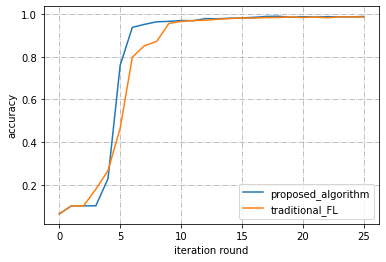

In [ ]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)

global_sess.run(tf.global_variables_initializer())

_,_,validate_global_model_accuracy_1=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_1,"proposed_algorithm",validate_global_model_accuracy_2,"traditional_FL","haha.pdf")

### bad_number=2 & traditinal_FL

In [ ]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_4=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.03963381  0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261665  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.0477825   0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.04496732  0.04770631  0.01590743]
[ 0.03638696  0.05964778 -0.04280256  0.03757261  0.0159936 ]
[ 0.04238008  0.05952498 -0.04300705  0.04498018  0.0156519 ]
[ 0.04230918  0.05601355 -0.04531269  0.04411602  0.01635975]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
0.10099999979138374
[ 0.0362646   0.05159143 -0.03350281  0.0437713   0.01878833]
[ 0.03102635  0.05181601 -0.03484018  0.04201371  0.01819403]
[ 0.03953102  0.04968795 -0.03434266  0.04067745  0.02010133]
[ 0.02830429  0.05291462 -0.03302465  0.04557147  0.0199214 ]
[ 0.03819413  0.0

### bad_number=2 & proposed_algorithm

accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336, 0.999999, 0.999999]
处理后 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336]
global_model_score: 0.06073333324243626
[ 0.03963381  0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261664  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.0477825   0.01787278]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.044

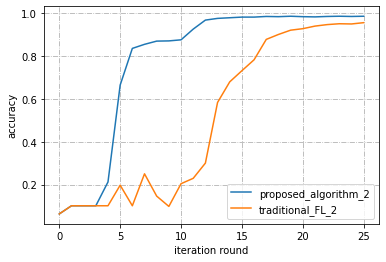

In [ ]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()



with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_3=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_3,"proposed_algorithm_2",validate_global_model_accuracy_4,"traditional_FL_2","haha_1.pdf")

### bad_number=5 & traditional_FL

In [ ]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,lr=0.001,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_8=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.0396338   0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261665  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.0477825   0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.04496732  0.04770631  0.01590743]
[ 0.03638696  0.05964777 -0.04280256  0.0375726   0.0159936 ]
[ 0.04238008  0.05952498 -0.04300705  0.04498018  0.0156519 ]
[ 0.04230917  0.05601355 -0.04531269  0.04411602  0.01635975]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
0.10099999979138374
[ 0.03172593  0.0433622  -0.02172009  0.039085    0.01749438]
[ 0.03027013  0.04354552 -0.0228443   0.03769043  0.01706368]
[ 0.03279126  0.04173367 -0.02598576  0.03595709  0.01806222]
[ 0.02720884  0.04502683 -0.

### bad_number=5 & proposed_algorithm

accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336, 0.999999, 0.999999, 0.999999, 0.999999, 0.999999]
处理后 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336]
global_model_score: 0.06073333324243626
[ 0.03963381  0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261665  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.0477825   0.01787278]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[

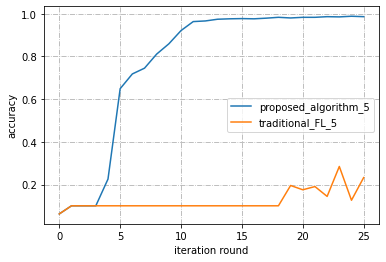

In [ ]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,lr=0.001,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_7=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_7,"proposed_algorithm_5",validate_global_model_accuracy_8,"traditional_FL_5","haha_2.pdf")


### 画图 & 保存原始数据

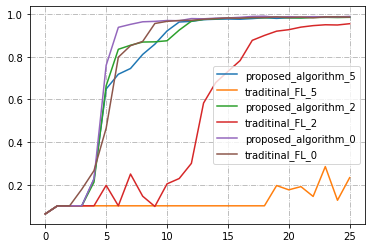

In [ ]:
plt.plot(validate_global_model_accuracy_7,label="proposed_algorithm_5")
plt.plot(validate_global_model_accuracy_8,label="traditinal_FL_5")
plt.plot(validate_global_model_accuracy_3,label="proposed_algorithm_2")
plt.plot(validate_global_model_accuracy_4,label="traditinal_FL_2")
plt.plot(validate_global_model_accuracy_1,label="proposed_algorithm_0")
plt.plot(validate_global_model_accuracy_2,label="traditinal_FL_0")

pd.DataFrame(validate_global_model_accuracy_7).to_csv("proposed_algorithm_5.csv")
pd.DataFrame(validate_global_model_accuracy_8).to_csv("traditinal_FL_5.csv")
pd.DataFrame(validate_global_model_accuracy_3).to_csv("proposed_algorithm_2.csv")
pd.DataFrame(validate_global_model_accuracy_4).to_csv("traditinal_FL_2.csv")
pd.DataFrame(validate_global_model_accuracy_1).to_csv("proposed_algorithm_0.csv")
pd.DataFrame(validate_global_model_accuracy_2).to_csv("traditinal_FL_0.csv")

plt.legend(loc="best")
plt.grid(linestyle='-.')
plt.savefig("bad_model_haha.pdf",format='pdf')  
plt.show()

### 重新定义local_train

In [ ]:
def local_train(all_user_FL):
  for user_FL in all_user_FL:
    if user_FL.isBad==False:
      user_FL.train()
    else:
      # 恶意提供坏模型—1
      # global_sess.run([tf.assign(t,0.0*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      # 恶意提供坏模型—2
      # global_sess.run([tf.assign(t,e-0.1*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      # 恶意不训练
      None
      # global_sess.run([tf.assign(t,e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
    print(global_sess.run(user_FL.parameters)[2][2][0][0][:5])

### bad_number=0 & traditional_FL & train_2

In [ ]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
tf.set_random_seed(2)
global_sess=tf.Session()

# 产生1个initial_model&10个用户的local FL model&global FL model
with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)

# with tf.variable_scope("backup_requester_FL"):
#   backup_requester_FL=FL("backup_requester_FL",global_sess,requester_data,requester_label)

global_sess.run(tf.global_variables_initializer())

validate_global_model_accuracy_2_=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.0396338   0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261664  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.04778251  0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.04496732  0.04770631  0.01590743]
[ 0.03638696  0.05964777 -0.04280256  0.0375726   0.0159936 ]
[ 0.04238008  0.05952498 -0.04300705  0.04498018  0.0156519 ]
[ 0.04230918  0.05601355 -0.04531269  0.04411602  0.01635975]
0.10099999979138374
[ 0.04055019  0.05918766 -0.0448219   0.04715835  0.02002073]
[ 0.03339234  0.06203291 -0.04479328  0.04832948  0.02108053]
[ 0.04407083  0.05769798 -0.04388477  0.04558866  0.02035505]
[ 0.0326995   0.06304334 -0.0414217   0.05281497  0.02335205]
[ 0.04332034  0.05869365 -0.04670521  0.04407101  0

### bad_number=0 & proposed_algorithm & train_2


accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336]
处理后 global_model_score: [0.0626666661972801, 0.060999999319513665, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336]
global_model_score: 0.06088888861445919
[ 0.0396338   0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531126  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261664  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.0477825   0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.04496732  0.04770631  0.01590743]
[ 0.03638696  0.05964777 -0.04280256  0.0375726   0.0159936 ]
[ 0.0423800

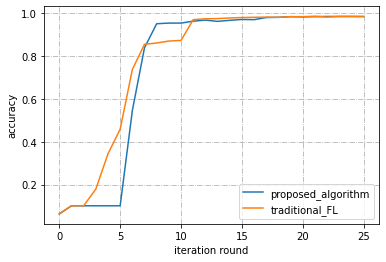

In [ ]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)

global_sess.run(tf.global_variables_initializer())

_,_,validate_global_model_accuracy_1_=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_1_,"proposed_algorithm",validate_global_model_accuracy_2_,"traditional_FL","haha_.pdf")

### bad_number=2 & traditinal_FL & train_2

In [ ]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_4_=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.0396338   0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946243 -0.0425985   0.04747961  0.01903727]
[ 0.04261665  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.04778251  0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.04496732  0.04770631  0.01590743]
[ 0.03638696  0.05964777 -0.04280256  0.03757261  0.0159936 ]
[ 0.04238009  0.05952498 -0.04300705  0.04498018  0.0156519 ]
[ 0.04230917  0.05601357 -0.04531269  0.04411602  0.01635974]
[ 0.03249801  0.04978321 -0.0528109   0.03728381  0.00884737]
[ 0.03249801  0.04978321 -0.0528109   0.03728381  0.00884737]
0.10099999979138374
[ 0.03953237  0.05850405 -0.04559723  0.04763348  0.01935915]
[ 0.03276681  0.06037796 -0.04495382  0.04663378  0.01965151]
[ 0.04427654  0.05640371 -0.04416257  0.04517607  0

### bad_number=2 & proposed_algorithm & train_2

accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336, 0.999999, 0.999999]
处理后 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336]
global_model_score: 0.06073333324243626
[ 0.03963381  0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261664  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.04778251  0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.044

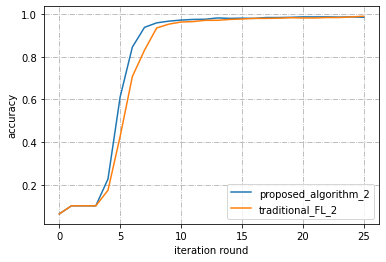

In [ ]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()



with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_3_=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_3_,"proposed_algorithm_2",validate_global_model_accuracy_4_,"traditional_FL_2","haha_1_.pdf")

### bad_number=5 & traditional_FL & train_2

In [ ]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,lr=0.001,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_8_=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.0396338   0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531126  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261664  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.0477825   0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[ 0.03964216  0.05692437 -0.04496732  0.04770631  0.01590743]
[ 0.03638696  0.05964777 -0.04280256  0.03757261  0.0159936 ]
[ 0.04238008  0.05952498 -0.04300705  0.04498018  0.0156519 ]
[ 0.04230917  0.05601355 -0.04531269  0.04411602  0.01635975]
[ 0.03249801  0.04978321 -0.0528109   0.03728381  0.00884737]
[ 0.03249801  0.04978321 -0.0528109   0.03728381  0.00884737]
[ 0.03249801  0.04978321 -0.0528109   0.03728381  0.00884737]
[ 0.03249801  0.04978321 -0.0528109   0.03728381  0.00884737]
[ 0.03249801  0.04978321 -0.0528109   0.03728381  0.00884737]
0.1039999

### bad_number=5 & proposed_algorithm & train_2

accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336, 0.999999, 0.999999, 0.999999, 0.999999, 0.999999]
处理后 global_model_score: [0.06533333361148835, 0.06533333354940019, 0.0626666661972801, 0.060999999319513665, 0.05666666707644859, 0.05466666650027038, 0.060666666862865315, 0.057999999572833395, 0.06399999993542832, 0.058999999798834336]
global_model_score: 0.06073333324243626
[ 0.0396338   0.05956094 -0.04767458  0.04756774  0.01872541]
[ 0.03531125  0.05946242 -0.0425985   0.04747961  0.01903727]
[ 0.04261665  0.05573371 -0.04367344  0.04666945  0.01828759]
[ 0.03830142  0.05949077 -0.04629444  0.0477825   0.01787277]
[ 0.04255861  0.05689679 -0.04633302  0.04750716  0.01793955]
[ 0.04233147  0.05948186 -0.04756033  0.04716884  0.01920216]
[

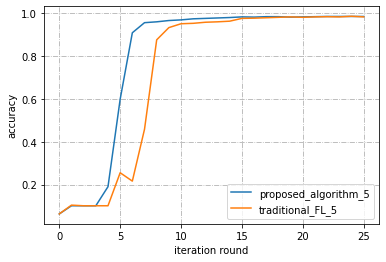

In [ ]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()



with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,lr=0.001,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_7_=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_7_,"proposed_algorithm_5",validate_global_model_accuracy_8_,"traditional_FL_5","haha_2_.pdf")


### 画图 & 保存原始数据

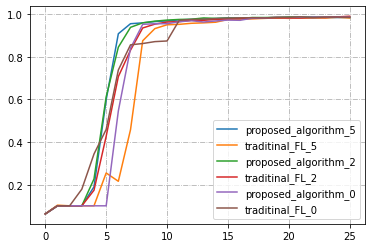

In [ ]:
plt.plot(validate_global_model_accuracy_7_,label="proposed_algorithm_5")
plt.plot(validate_global_model_accuracy_8_,label="traditinal_FL_5")
plt.plot(validate_global_model_accuracy_3_,label="proposed_algorithm_2")
plt.plot(validate_global_model_accuracy_4_,label="traditinal_FL_2")
plt.plot(validate_global_model_accuracy_1_,label="proposed_algorithm_0")
plt.plot(validate_global_model_accuracy_2_,label="traditinal_FL_0")

pd.DataFrame(validate_global_model_accuracy_7_).to_csv("proposed_algorithm_5_.csv")
pd.DataFrame(validate_global_model_accuracy_8_).to_csv("traditinal_FL_5_.csv")
pd.DataFrame(validate_global_model_accuracy_3_).to_csv("proposed_algorithm_2_.csv")
pd.DataFrame(validate_global_model_accuracy_4_).to_csv("traditinal_FL_2_.csv")
pd.DataFrame(validate_global_model_accuracy_1_).to_csv("proposed_algorithm_0_.csv")
pd.DataFrame(validate_global_model_accuracy_2_).to_csv("traditinal_FL_0_.csv")

plt.legend(loc="best")
plt.grid(linestyle='-.')
plt.savefig("initial_model_haha.pdf",format='pdf') 

plt.show()